## This assignment is designed for automated pathology detection for Medical Images in a realistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:



The following four cells are only relevant for developing in Google Colab. Comment them out if you're working in another environment.'

In [1]:
# Access google drive file system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# navigate to correct directory (change this to whatever is appropriate in your drive)
import os
os.chdir('/content/drive/MyDrive/FourthBrain/Week 8/cv_midterm')

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 22 04:21:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
# !unzip 'Data.zip'

In [6]:
# imports
from datetime import datetime
from tqdm import tqdm
import csv
import os
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score

import tensorflow as tf
from tensorflow import GradientTape

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Lambda, Activation
from tensorflow.keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier

# Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, parameters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```

### First, we'll load our labels and images that correspond to `Diabetic Retinopathy`, `Glaucoma`, and `normal` categories.

In [7]:
# Load labels 
all_data = pd.read_csv('./Data/train/train.csv')
print(f'Full data is : {len(all_data)} items long')
all_data.head()

Full data is : 3435 items long


,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [8]:
# Just take columns 0, 2, 3, -1 for our image names and relevant categories
data = all_data[["filename", "diabetic retinopathy", "glaucoma", "normal"]]
# Make a column that's 1 when others are 0 for 'other'
data['other'] = np.where((data['diabetic retinopathy'] == 0) &
                         (data['glaucoma'] == 0) &
                         (data['normal'] == 0), 1, 0)

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,filename,diabetic retinopathy,glaucoma,normal,other
0,c24a1b14d253.jpg,0,0,0,1
1,9ee905a41651.jpg,0,0,0,1
2,3f58d128caf6.jpg,0,1,0,0
3,4ce6599e7b20.jpg,0,0,0,1
4,0def470360e4.jpg,0,0,0,1


### Next, we'll explore our data and generate our Train/Test splits.
1. Exploratory data analysis (Frequency of labels)

In [9]:
for i in data.columns[1:]:
  print(f"Number of examples of {i} in data:", data[i].value_counts()[1])

Number of examples of diabetic retinopathy in data: 755
Number of examples of glaucoma in data: 597
Number of examples of normal in data: 525
Number of examples of other in data: 1577


Clearly, this skews towards "other", but let's see if that imbalance messes with our predictions.

Now, we'll check how much overlap is in our data, i.e. how many images have multiple classifications. 

Note: in this case, because of the way the 'normal' classification works and because of how we constructed our 'Other' column, the only possible overlap would be between DR and Glaucoma.

In [10]:
len(data.loc[(data['diabetic retinopathy'] == 1) & (data['glaucoma'] == 1)])

19

### Generation of Training, Test splits (70/30 split)

In [11]:
# Train/test split
train, test = train_test_split(data, test_size=0.3, random_state=57)

In [12]:
for i in [train, test]:
  print(i.shape)

(2404, 5)
(1031, 5)


In [13]:
# We have 4 classes in our dataset
num_classes = train.shape[1] - 1
num_classes

4

## Build Generators

In [14]:
# data_gen_args = dict( 
#     rotation_range=10.,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     zoom_range=0.2,
#     channel_shift_range=0.05,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='constant',
#     data_format="channels_last",
#     rescale=1./255
# )

image_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)#**data_gen_args, )
BATCH_SIZE = 128

In [15]:
PATH='./Data/'
if not os.path.exists(PATH+'aug/train/'):
    os.makedirs(PATH+'aug/train')

In [16]:
train_generator = image_datagen.flow_from_dataframe(
    dataframe=train,
    directory="./Data/train/train/",
    x_col="filename",
    y_col=["diabetic retinopathy", "glaucoma", "normal", "other"],
    save_to_dir=PATH+'aug/train/',
    batch_size=BATCH_SIZE,
    seed=57,
    class_mode='raw',
    subset='training'
)

valid_generator = image_datagen.flow_from_dataframe(
    dataframe=train,
    directory="./Data/train/train/",
    x_col="filename",
    y_col=["diabetic retinopathy", "glaucoma", "normal", "other"],
    save_to_dir=PATH+'aug/train/',
    batch_size=BATCH_SIZE,
    seed=57,
    class_mode='raw',
    subset='validation'
)

test_generator = image_datagen.flow_from_dataframe(
    dataframe=test,
    directory="./Data/train/train/",
    x_col="filename",
    y_col=["diabetic retinopathy", "glaucoma", "normal", "other"],
    save_to_dir=PATH+'aug/train/',
    batch_size=BATCH_SIZE,
    seed=57,
    class_mode='raw'
)

Found 1803 validated image filenames.
Found 601 validated image filenames.
Found 1031 validated image filenames.


## Model

The first model we'll try is AlexNet, since it's lightweight and [effective on these types of classification problems](https://www.sciencedirect.com/science/article/abs/pii/S0045790618334190). I'll try it first with only the green channel of the images, since that was effective the last time I used it (and in the paper cited above).

Since there are only 19 examples of overlap in our thousands of examples, we'll be doing multiclass classification, instead of multilabel.

In [17]:
# AlexNet
class AlexNet(Sequential):
   def __init__(self, input_shape, num_classes, **kwargs):
    super().__init__()
    # Only take green channel
    self.add(Lambda(lambda x: x[:,:,:,1:2], input_shape=input_shape))

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, 
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal', name='last_conv'))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None, name='max_pool'))
    

    self.add(Flatten(name='flatten'))
    
    self.add(Dense(num_classes, name='dense'))

    self.add(Activation('softmax'))

    self.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [18]:
model = AlexNet((256, 256, 3), num_classes)
model_name = 'AlexNet3'
# def create_model(optimizer='adam', learn_rate=0.01, momentum=0.0):
#   model = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)
#   model.compile(optimizer=optimizer,
#                 loss = 'binary_crossentropy', 
#                 metrics=['accuracy'])
#   learn_rate=learn_rate,
#   momentum=momentum,
#   return model
# model = create_model()

## Training

First, we'll set all of our callbacks for model training

In [19]:
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 30           # Parameter used for reducing learning rate


In [20]:
# Directory for tensorboard logs
%load_ext tensorboard
logdir = "logs/scalars3/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Reduce LR on plateau callback
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
#                                         factor=LEARNING_RATE_SCHEDULE_FACTOR,
#                                         patience=LEARNING_RATE_SCHEDULE_PATIENCE,
#                                         min_lr=1e-8, verbose=1)

callbacks = [tensorboard_callback]

In [ ]:
STEP_SIZE_TRAIN = int(train_generator.n//train_generator.batch_size)
STEP_SIZE_VALID= int(valid_generator.n//valid_generator.batch_size)
STEP_SIZE_TEST = int(test_generator.n//test_generator.batch_size)
EPOCHS = 75

model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=EPOCHS,
          verbose=1,
          callbacks=callbacks
)

Epoch 1/75
14/14 [==============================] - 1386s 102s/step - loss: 8.3433 - accuracy: 0.3570 - val_loss: 303.4497 - val_accuracy: 0.1699
Epoch 2/75
14/14 [==============================] - 314s 24s/step - loss: 2.1096 - accuracy: 0.4308 - val_loss: 81.4957 - val_accuracy: 0.2324
Epoch 3/75
14/14 [==============================] - 73s 5s/step - loss: 1.4317 - accuracy: 0.4566 - val_loss: 15.6536 - val_accuracy: 0.2148
Epoch 4/75
14/14 [==============================] - 70s 5s/step - loss: 1.3410 - accuracy: 0.5036 - val_loss: 3.9641 - val_accuracy: 0.3125
Epoch 5/75
14/14 [==============================] - 72s 5s/step - loss: 1.3494 - accuracy: 0.5018 - val_loss: 1.8592 - val_accuracy: 0.4336
Epoch 6/75
14/14 [==============================] - 71s 5s/step - loss: 1.0822 - accuracy: 0.5714 - val_loss: 1.9116 - val_accuracy: 0.3574
Epoch 7/75
14/14 [==============================] - 69s 5s/step - loss: 1.3431 - accuracy: 0.5355 - val_loss: 2.4172 - val_accuracy: 0.2520
Epoch 8/75

In [ ]:
# In case you need to reload the tensorboard
# %reload_ext tensorboard

In [ ]:
%tensorboard --logdir logs/scalars2/

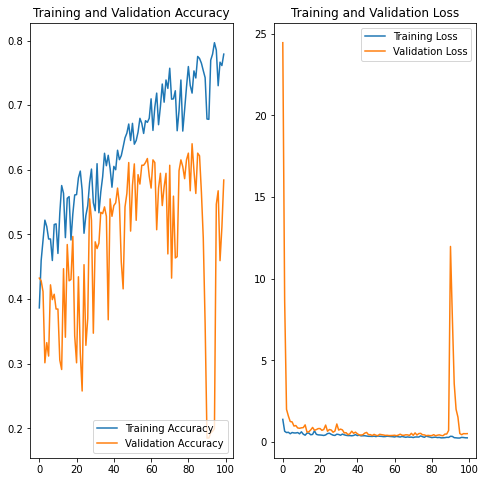

In [ ]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save_weights(f'./models/{model_name}Weights.h5')

In [ ]:
# model.load_weights(f'./models/{model_name}Weights.h5')

## Testing / Results

### Predict

Let's get our predictions from the model for every example in our 30% test split.

In [ ]:
prediction_values = model.predict(X_test)#np.argmax(model.predict(X_test), axis=-1)

###Now, let's check our accuracy

In [ ]:
def get_scores(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  print(f'Accuracy = {accuracy}')
  print(f'F1 = {f1}')
  print(f'Precision = {precision}')
  print(f'Recall = {recall}')
  return [accuracy, f1, precision, recall]

Accuracy = 0.7633365664403492
F1 = 0.11594202898550725
Precision = 0.26229508196721313
Recall = 0.07441860465116279
Confusion matrix =


array([[771,  45],
       [199,  16]])

In [ ]:
first_scores = get_scores(test.iloc[:,1:], prediction_values)

This is honestly pretty solid, especially considering we haven't even started to adjust our threshold for our individual categorical predictions!

In [ ]:
# format how numpy displays floats for the following cells
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

[0 1 0 0] [0.13 0.07 0.00 0.65]
[1 0 0 0] [0.04 0.04 0.00 0.89]
[0 0 0 1] [0.13 0.07 0.00 0.66]
[0 0 0 1] [0.00 0.41 0.00 0.76]
[0 0 0 1] [0.31 0.04 0.00 0.55]
[0 1 0 0] [0.05 0.94 0.00 0.06]


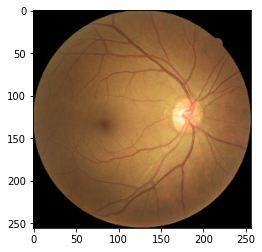

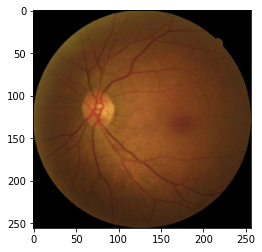

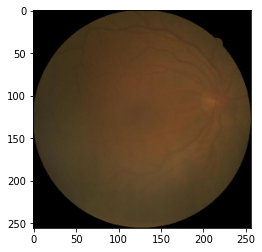

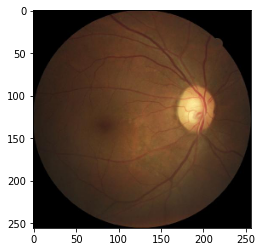

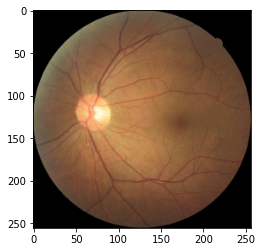

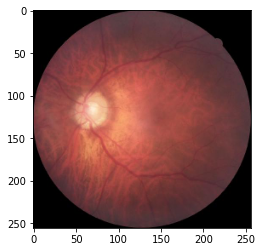

In [ ]:
# Display predictions for an image + the actual labels
for num in range(92,98):
  plt.subplots(1,1)
  plt.imshow(test[num])
  print(test.iloc[num,1:], prediction_values[num])

plt.show()

## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

I'm borrowing many of the following insights and functions from the [Keras GradCam documentation](https://keras.io/examples/vision/grad_cam/) and Rana Ahmad's [excellent project for creating heatmaps](https://github.com/taimur1871/image_heatmaps/blob/main/heat_map_obj_detection_v2.ipynb). He and I talked through that process a bit together and shared some resources when we worked on this in Week 6, and I think his implementation is awesome. 

Normally, I'd put these functions in a `helper_functions.py` file, but I'm putting them here in the notebook so you can see them.

In [ ]:
# Get model layer names from summary
model.summary()

Model: "alex_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 96)        11712     
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 256)       0

In [ ]:
# Relevant model names
classifier_layer_names = ['max_pool', 'flatten', 'dense']
last_conv_layer_name = 'last_conv'

In [ ]:
# slightly modified from the Keras doc implementation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

  classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name  in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = tf.keras.Model(classifier_input, x)

  with tf.GradientTape() as tape:
      # Compute activations of the last conv layer and make the tape watch it
      last_conv_layer_output = last_conv_layer_model(img_array)
      tape.watch(last_conv_layer_output)
      # Compute class predictions
      preds = classifier_model(last_conv_layer_output)
      top_pred_index = tf.argmax(preds[0])
      top_class_channel = preds[:, top_pred_index]

  grads = tape.gradient(top_class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
      last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

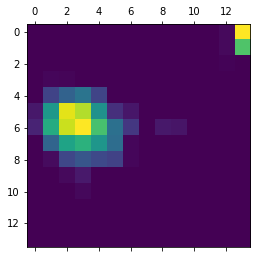

In [ ]:
# Use a test example to make sure our function works
heatmap = make_gradcam_heatmap(np.expand_dims(X_test[0], axis=0),
                                              model,
                                              last_conv_layer_name, 
                                              classifier_layer_names)

plt.matshow(heatmap)

In [ ]:
# function to cover image with heat map
def cover_img(img_path, heatmap):
  # Use cv2 to load the original image
  img_original = cv2.imread(img_path)

  # set the intensity map at 0.5
  INTENSITY = 0.5

  # Resize the heatmap to have the same size as the original image
  heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

  # Convert the heatmap to RGB
  heatmap_resized = np.uint8(255 * heatmap_resized)

  # We apply the heatmap to the original image
  heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

  # processed image
  img_new = heatmap_resized * INTENSITY + img_original

  return img_new

In [ ]:
# function to load images
def load_images(img_path):
  img = image.load_img(img_path, target_size=(256,256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  return x

In [ ]:
def display_heatmap():
  # Shows image class - 0 for DR, 1 for glau, 2 for normal, 3 for other, etc.
  # Shows original image
  # Shows heatmap overlayed
  # Saves overlay

Image is class: Normal


/usr/local/lib/python3.6/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'numpy.ndarray'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

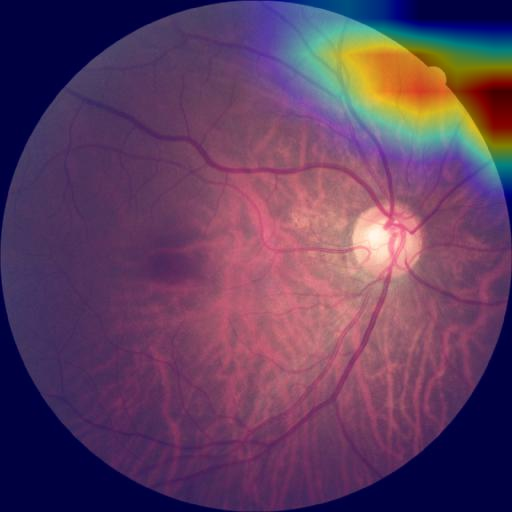

Image is class: Other


<IPython.core.display.Image object>

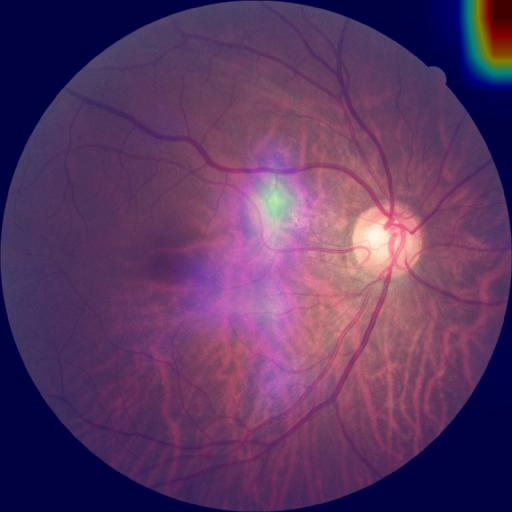

Image is class: Other


<IPython.core.display.Image object>

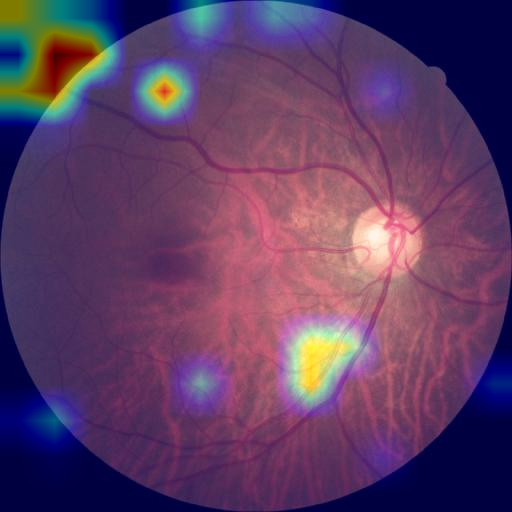

Image is class: Glaucoma


<IPython.core.display.Image object>

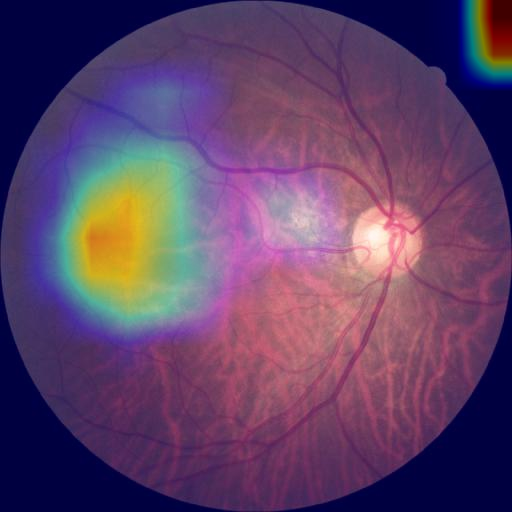

Image is class: Other


<IPython.core.display.Image object>

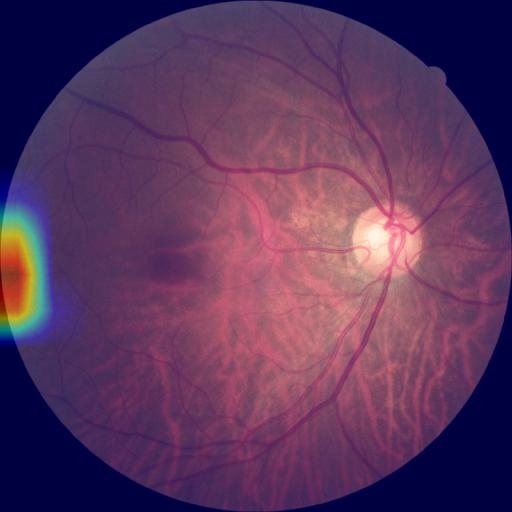

In [ ]:
class_dict = {0: "DR", 1: "Glaucoma", 2: "Normal", 3: "Other"}

for i in range(10, 15):
  # pic_path = os.path.join(img_dir, pic)
  # print(pic_path)
  # img = load_images(pic_path)
  # img = tf.keras.preprocessing.image.load_img(pic_path)
  # img = tf.keras.preprocessing.image.img_to_array(img)
  pic = np.expand_dims(X_train[i], axis=0)
  print("Image is class:", class_dict.get(np.argmax(y_train[i], axis=-1)))
  heatmap = make_gradcam_heatmap(pic,
                                  model,
                                  last_conv_layer_name, 
                                  classifier_layer_names)
  # plt.matshow(heatmap)
  display(Image(pic))
  covered_img = cover_img(pic_path, heatmap)
  cv2_imshow(covered_img)
  # heatmap = np.uint8(255 * heatmap)
  # jet = cm.get_cmap("jet")

  # # We use RGB values of the colormap
  # jet_colors = jet(np.arange(256))[:, :3]
  # jet_heatmap = jet_colors[heatmap]

  # # We create an image with RGB colorized heatmap
  # jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  # jet_heatmap = jet_heatmap.resize((pic.shape[1], pic.shape[0]))
  # jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # # Superimpose the heatmap on original image
  # superimposed_img = jet_heatmap * 0.4 + pic
  # superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  # # Save the superimposed image
  # save_path = f"{pic}_cam.jpg"
  # covered_img.save(save_path)
  # # Display Grad CAM
  # display(Image(save_path))

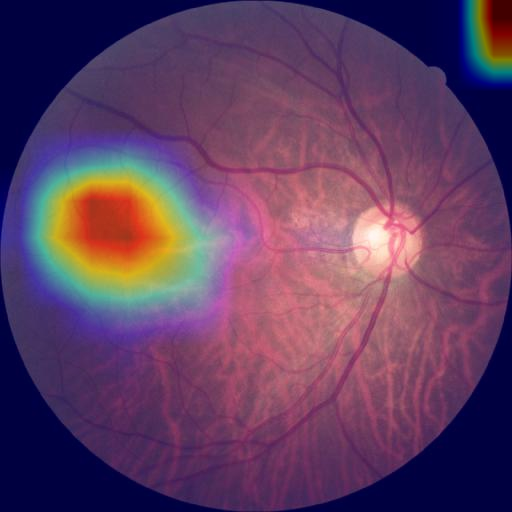

In [ ]:
  heatmap = make_gradcam_heatmap(np.expand_dims(X_test[0], axis=0),
                                  model,
                                  last_conv_layer_name, 
                                  classifier_layer_names)
  # plt.matshow(heatmap)
  # cv2_imshow(img)
  cv2_imshow(cover_img(pic_path, heatmap))
  # heatmap = np.uint8(255 * heatmap)
  # jet = cm.get_cmap("jet")

  # # We use RGB values of the colormap
  # jet_colors = jet(np.arange(256))[:, :3]
  # jet_heatmap = jet_colors[heatmap]

  # # We create an image with RGB colorized heatmap
  # jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  # jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  # jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  # superimposed_img = jet_heatmap * 0.4 + img
  # superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  # # Save the superimposed image
  save_path = "X_train[0]_cam.jpg" # turn into f string for image name
  superimposed_img.save(save_path)
  # Display Grad CAM
  # display(Image(save_path))

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unlabelelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```
## Good Luck!

## Loading unlabeled data

In [ ]:
# ul_train_images = []
# ul_dir = './Data/test/test/'
# ul_list = os.listdir(ul_dir)
# img_size = 256
# for i in tqdm(range(len(ul_list))):
#   img = ul_dir + ul_list[i]
#   img = image.load_img(img, target_size=(img_size,img_size,3))
#   img = image.img_to_array(img)
#   img = img/255
#   ul_train_images.append(img)
# X_ul = np.array(ul_train_images)

100%|██████████| 350/350 [01:15<00:00,  4.65it/s]


In [ ]:
# with open('./Data/X_ul256.npy', 'wb') as f:
#   np.save(f, X_ul)

In [ ]:
# Load previously saved X data
X_ul = np.load('./Data/X_ul256.npy')

In [ ]:
X_ul.shape

(350, 256, 256, 3)

In [ ]:
# Create model whose output is the output of our og model's dense layer
dense_layer = 'dense'
dense_model = Model(inputs=model.input,
                    outputs=model.get_layer(dense_layer).output)
# Pass labeled and unlabeled data
l_dense_output = dense_model.predict(train)
ul_dense_output = dense_model.predict(X_ul)

In [ ]:
# concatenate dense outputs 
full_dense_output = np.concatenate((l_dense_output, ul_dense_output), axis=0)
full_dense_output.shape

(2754, 4)

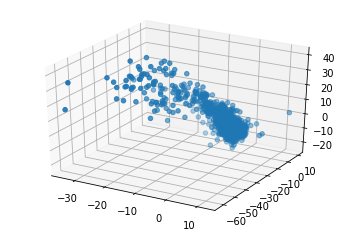

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = l_dense_output[:, 0]
ys = l_dense_output[:, 1]
zs = l_dense_output[:, 2]

ax.scatter(xs, ys, zs)

plt.show()

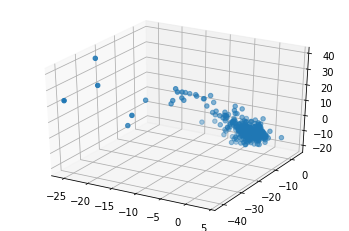

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = ul_dense_output[:, 0]
ys = ul_dense_output[:, 1]
zs = ul_dense_output[:, 2]

ax.scatter(xs, ys, zs)

plt.show()

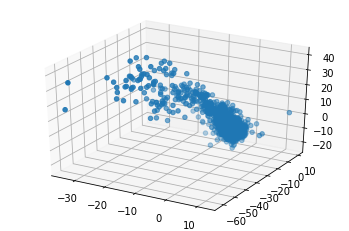

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = full_dense_output[:, 0]
ys = full_dense_output[:, 1]
zs = full_dense_output[:, 2]

ax.scatter(xs, ys, zs)

plt.show()

In [ ]:
print(y_train[:5], y_train.shape)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]] (2404, 4)


In [ ]:
diff = full_dense_output.shape[0] - train.shape[0]
print(diff)

350


In [ ]:
class_labels = np.argmax(train.iloc[:,1:], axis=1).reshape(-1,1)
print(class_labels[:10], class_labels.shape)

[[2]
 [2]
 [3]
 [1]
 [1]
 [3]
 [0]
 [2]
 [3]
 [0]] (2404, 1)


In [ ]:
# pad y_train with -1s to make it as long as concatenated data
dummies = np.full((350, 1), -1)
print(dummies.shape)
y_full = np.concatenate((class_labels, dummies), axis=0)
print("y shape", y_full.shape)
print("x shape", full_dense_output.shape)

(350, 1)
y shape (2754, 1)
x shape (2754, 4)


In [ ]:
from sklearn.semi_supervised import LabelSpreading
lp_model = LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(full_dense_output, y_full)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelSpreading(alpha=0.2, gamma=0.25, kernel='rbf', max_iter=20, n_jobs=None,
               n_neighbors=7, tol=0.001)

In [ ]:
predicted_labels = lp_model.transduction_

In [ ]:
y_full = np.array(pd.get_dummies(predicted_labels))

In [ ]:
print(X_train.shape, X_ul.shape)
X_full = np.concatenate((X_train, X_ul), axis=0)
X_full.shape

(2404, 256, 256, 3) (350, 256, 256, 3)


(2754, 256, 256, 3)

In [ ]:
epochs = 30

training_history2 = model.fit(
    X_full, # input
    y_full, # output
    batch_size=128,
    validation_split=0.2,
    verbose=1, 
    epochs=epochs,
)

Epoch 1/30
18/18 [==============================] - 5s 234ms/step - loss: 0.2157 - accuracy: 0.8438 - val_loss: 0.2845 - val_accuracy: 0.7768
Epoch 2/30
18/18 [==============================] - 3s 190ms/step - loss: 0.1898 - accuracy: 0.8575 - val_loss: 0.2923 - val_accuracy: 0.7550
Epoch 3/30
18/18 [==============================] - 3s 183ms/step - loss: 0.1793 - accuracy: 0.8747 - val_loss: 0.2915 - val_accuracy: 0.7786
Epoch 4/30
18/18 [==============================] - 3s 183ms/step - loss: 0.1647 - accuracy: 0.8915 - val_loss: 0.3105 - val_accuracy: 0.7423
Epoch 5/30
18/18 [==============================] - 3s 186ms/step - loss: 0.1455 - accuracy: 0.9128 - val_loss: 0.3379 - val_accuracy: 0.6933
Epoch 6/30
18/18 [==============================] - 3s 186ms/step - loss: 0.1302 - accuracy: 0.9206 - val_loss: 0.3317 - val_accuracy: 0.7205
Epoch 7/30
18/18 [==============================] - 3s 184ms/step - loss: 0.1176 - accuracy: 0.9351 - val_loss: 0.3239 - val_accuracy: 0.7314
Epoch 

In [ ]:
prediction_values2 = model.predict(X_test)

In [ ]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss

print(f'Coverage error = {coverage_error(y_test, prediction_values2)}')
print(f'Label ranking average precision = {label_ranking_average_precision_score(y_test, prediction_values2)}')
print(f'Ranking loss = {label_ranking_loss(y_test, prediction_values2)}')

Coverage error = 1.4471387002909797
Label ranking average precision = 0.8258163595215009
Ranking loss = 0.14775299062398964


In [ ]:
threshold = 0.5
pred_labels2 = np.where(prediction_values2 > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score
print(f'Accuracy = {accuracy_score(y_test[:,0], pred_labels2[:,0])}')
print(f'F1 = {f1_score(y_test[:,0], pred_labels2[:,0])}')
print(f'Precision = {precision_score(y_test[:,0], pred_labels2[:,0])}')
print(f'Recall = {recall_score(y_test[:,0], pred_labels2[:,0])}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(y_test[:,0], pred_labels2[:,0])

Accuracy = 0.8069835111542192
F1 = 0.45776566757493187
Precision = 0.5526315789473685
Recall = 0.39069767441860465
Confusion matrix =


array([[748,  68],
       [131,  84]])

In [ ]:
print(f'Accuracy = {accuracy_score(y_test[:,1], pred_labels2[:,1])}')
print(f'F1 = {f1_score(y_test[:,1], pred_labels2[:,1])}')
print(f'Precision = {precision_score(y_test[:,1], pred_labels2[:,1])}')
print(f'Recall = {recall_score(y_test[:,1], pred_labels2[:,1])}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(y_test[:,1], pred_labels2[:,1])

Accuracy = 0.8845780795344326
F1 = 0.6046511627906976
Precision = 0.674074074074074
Recall = 0.5481927710843374
Confusion matrix =


array([[821,  44],
       [ 75,  91]])

In [ ]:
print(f'Accuracy = {accuracy_score(y_test[:,2], pred_labels2[:,2])}')
print(f'F1 = {f1_score(y_test[:,2], pred_labels2[:,2])}')
print(f'Precision = {precision_score(y_test[:,2], pred_labels2[:,2])}')
print(f'Recall = {recall_score(y_test[:,2], pred_labels2[:,2])}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(y_test[:,2], pred_labels2[:,2])

Accuracy = 0.962172647914646
F1 = 0.8792569659442724
Precision = 0.8502994011976048
Recall = 0.9102564102564102
Confusion matrix =


array([[850,  25],
       [ 14, 142]])

In [ ]:
preds2 = np.argmax(model.predict(X_test), axis=-1)
preds2[:5]

array([1, 2, 0, 3, 3])

In [ ]:
y_cat2 = np.argmax(y_test, axis=-1)
y_cat2[:5]

array([3, 0, 3, 3, 3])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score

print(f'Accuracy = {accuracy_score(y_cat, preds2)}')
print('F1 =', f1_score(y_cat, preds2, average='weighted'))
print('Precision =', precision_score(y_cat, preds2, average='weighted'))
print('Recall =', recall_score(y_cat, preds2, average='weighted'))
# # Display the confusion matrix
# print('Confusion matrix =')
# confusion_matrix(y_cat, preds2)

Accuracy = 0.6896217264791464
F1 = 0.6821423559846487
Precision = 0.6795526504721112
Recall = 0.6896217264791464
